원래 예제 분석


**1. 로이터 데이터**

In [ ]:
knitr::opts_chunk$set(warning = FALSE, message = FALSE)

 R 코드에서 knitr 패키지를 사용할 때 코드 청크(chunk)의 옵션을 설정하는 코드
 설정한 옵션들은 R 코드 청크를 실행할 때 경고 메시지와 일반 메시지를 출력하지 않도록 설정하여 문서를 깔끔하고 읽기 쉽게 만들어줬다.

In [ ]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
library(keras)

R에서 딥러닝 모델을 쉽게 구축하고 학습할 수 있게 해주는 Keras 패키지를 설치하고 로드한다.

In [ ]:
reuters <- dataset_reuters(num_words = 10000)

In [ ]:
c(c(train_data, train_labels), c(test_data, test_labels)) %<-% reuters

Keras에서 제공하는 Reuters 뉴스 데이터를 로드하는데 모델 학습의 효율성을 높이기 위해 자주 나타나는 단어만 사용하기위해 가장 자주 나타나는 10,000개의 단어만 사용다.

그런다음 ,  reuters 데이터셋을 훈련 데이터와 테스트 데이터로 분할하는 작업을 수행한다.

In [ ]:
length(train_data)

[1] 8982

In [ ]:
length(test_data)

[1] 2246

length(train_data): train_data와 test_data 리스트의 길이를 계산합니다. 이 리스트들에는 훈련 데이터와 테스트 데이터에 포함된 뉴스 기사들의 수가 저장되어 있습니다. 출력값 8982는 훈련 데이터셋에 8982개의 뉴스 기사가 포함되어 있다는 것을 의미하며 2246는 테스트 데이터셋에 2246개의 뉴스 기사가 포함되어 있다는 것을 의미합니다.


In [ ]:
train_data[[1]]

[1]    1    2    2    8   43   10  447    5   25  207  270    5 3095  111   16
[16]  369  186   90   67    7   89    5   19  102    6   19  124   15   90   67
[31]   84   22  482   26    7   48    4   49    8  864   39  209  154    6  151
[46]    6   83   11   15   22  155   11   15    7   48    9 4579 1005  504    6
[61]  258    6  272   11   15   22  134   44   11   15   16    8  197 1245   90
[76]   67   52   29  209   30   32  132    6  109   15   17   12

첫 번째 훈련 샘플(뉴스 기사)을 나타내며, 숫자의 시퀀스가 출력됐다. 출력된 숫자들은 각 단어를 고유하게 나타내는 인덱스이다.

In [ ]:
word_index <- dataset_reuters_word_index()
reverse_word_index <- names(word_index)
names(reverse_word_index) <- word_index
decoded_newswire <- sapply(train_data[[1]], function(index) {
  # Note that our indices were offset by 3 because 0, 1, and 2
  # are reserved indices for "padding", "start of sequence", and "unknown".
  word <- if (index >= 3) reverse_word_index[[as.character(index - 3)]]
  if (!is.null(word)) word else "?"
})

 뉴스 데이터셋에서 단어 인덱스를 실제 단어로 디코딩하는 작업을 수행한다. 이를 통해 숫자로 구성된 뉴스 기사를 원래의 텍스트 형태로 변환한다.
  각 숫자는 데이터셋의 단어 인덱스에 대응되며, 인덱스 3 이상은 실제 단어로 변환되고, 0, 1, 2는 특별한 인덱스로 처리되어 변환되지 않는다.

 decoded_newswire는 첫 번째 뉴스 기사의 단어들로 구성된 벡터가 되어 숫자 시퀀스 형태의 데이터를 사람이 읽을 수 있는 텍스트 형태로 변환한다.

In [ ]:
cat(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3

'?'는 인덱스가 0, 1, 2인 특별한 경우 또는 변환되지 않은 단어이다.

In [ ]:
train_labels[[1]]

[1] 3

첫 번째 훈련 샘플의 카테고리를 반환하여, 이 뉴스 기사의  카테고리가 3 이라는것을 알 수 있다.



**2. 데이터 준비**

In [ ]:
vectorize_sequences <- function(sequences, dimension = 10000) {
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    results[i, sequences[[i]]] <- 1
  results
}

vectorize_sequences 함수를 만들어서 뉴스 기사의 단어 인덱스 시퀀스를 고정된 크기의 이진 벡터로 변환하게 합니다. 각 벡터는 해당 뉴스 기사에 특정 단어가 포함되어 있는지를 나타냅니다.

In [ ]:
x_train <- vectorize_sequences(train_data)
x_test <- vectorize_sequences(test_data)

이 코드는 'train_data'와 'test_data'를 벡터화하여 신경망 모델의 입력으로 사용할 수 있는 형태로 변환한다. 'x_train'은 'train_data'의 각 뉴스 기사를 10,000 차원의 이진 벡터로 표현한 행렬이 된다.

In [ ]:
to_one_hot <- function(labels, dimension = 46) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}

one_hot_train_labels <- to_one_hot(train_labels)
one_hot_test_labels <- to_one_hot(test_labels)

레이블을 원-핫 인코딩으로 변환하는 과정을 수행한다. 각 벡터는 해당 레이블에 해당하는 위치만 1이고 나머지는 0인 형태이다.

train_labels,test_labels를 원-핫 인코딩하여 one_hot_train_labels,one_hot_test_labels에 저장한다.
그러 one_hot_train_labels, one_hot_test_labels는 train_labels,test_labels의 각 레이블을 46 차원의 이진 벡터로 표현한 행렬이 된다.


In [ ]:
one_hot_train_labels <- to_categorical(train_labels)
one_hot_test_labels <- to_categorical(test_labels)

레이블을 원-핫 인코딩으로 쉽게 변환할 수 있게 해주는 Keras 라이브러리의 to_categorical 함수를 사용하여 train_labels와 test_labels를 원-핫 인코딩으로 변환하는 작업을 수행한다.

**3. 망구축**

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

 `keras_model_sequential()` 함수를 사용하여 순차 모델을 생성한다.

 그 다음, Dense Layer을 추가한다. 첫 번째 층에는 64개의 뉴런이 있으며, 활성화 함수로 ReLU를 사용한다. 이 층은 입력 데이터의 형상을 10,000 차원의 벡터로 지정한다.
두 번째 밀집층도 첫 번째 층과 마찬가지로 64개의 뉴런과 ReLU 활성화 함수를 사용한다.

마지막으로, 출력층을 추가한다. 출력층에는 46개의 뉴런이 있으며, 활성화 함수로 Softmax를 사용한다. 출력층의 출력은 각 카테고리에 속할 확률로 해석된다.

결론적으로, 이 모델은 뉴스 기사의 벡터화된 입력을 받아, 각 뉴스 기사가 46개의 카테고리 중 어느 하나에 속할 확률을 예측하는 것이다.

In [ ]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

신경망 모델을 컴파일하여 학습 준비를 완료하는 부분이다. RMSprop 최적화 알고리즘을 사용하여 모델의 가중치를 업데이트하며, 범주형 교차 엔트로피 손실 함수를 통해 손실을 계산하고, 정확도를 평가 지표로 설정하여 모델의 성능을 모니터링한다. 이 과정은 모델이 데이터를 학습하고 예측을 개선해 나가는 데 필요한 설정을 완료하는 단계이다.

**접근법 검증하기**

In [ ]:
val_indices <- 1:1000

x_val <- x_train[val_indices,]
partial_x_train <- x_train[-val_indices,]

y_val <- one_hot_train_labels[val_indices,]
partial_y_train = one_hot_train_labels[-val_indices,]

과적합을 방지하고 모델의 일반화 성능을 평가하기위해 훈련 데이터와 레이블을 훈련 세트와 검증 세트로 나눈다. 이를 통해 모델이 훈련되는 동안 검증 세트를 사용해 모델의 성능을 평가할 수 있다.

In [ ]:
history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)

모델을 20번 반복하여 학습시키며, 각 반복마다 512개의 샘플을 사용하여 가중치를 업데이트하며 모델의 성능을 평가하기 위해 훈련되지 않은 별도의 검증 데이터를 사용한다. 이 과정에서 loss와 정확도 등의 정보가 history에 저장되며 이를 통해 모델의 성능 변화를 모니터링할 수 있다.

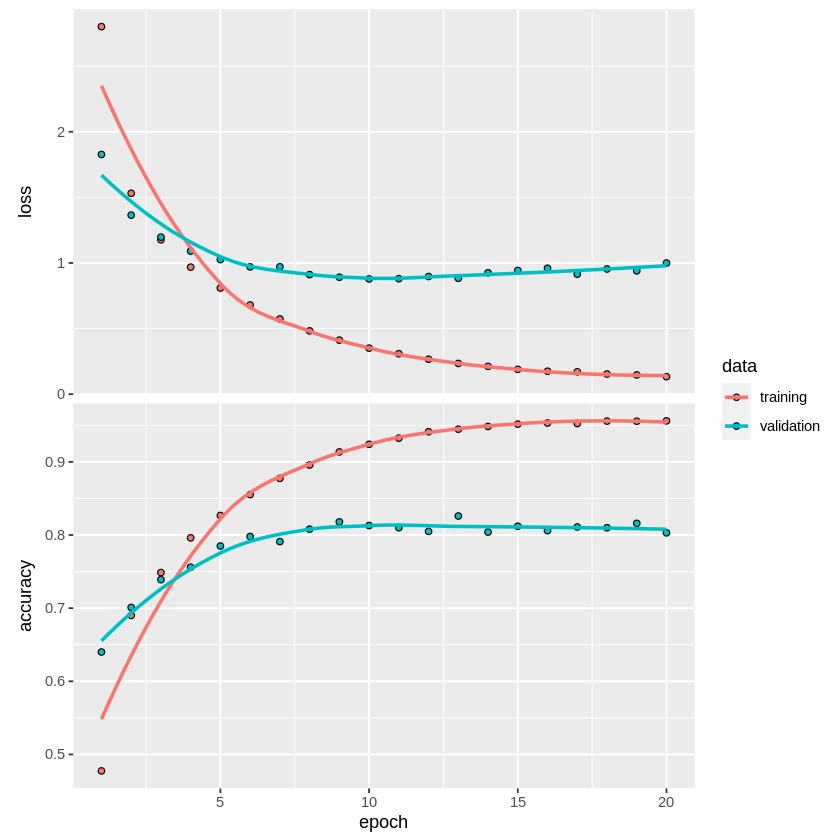

In [ ]:
plot(history)

모델이 학습되는 동안의 loss와 정확도 등의 정보를 나타낸 그래프이다.

모델은 훈련 데이터에 대해 잘 학습하고 있음을 보여주며 검증 데이터에 대해서는 잘 진행하다가 중간에 더 이상 성능이 개선되지 않고 있음을 보여준다.
또한 에포크가 증가함에 따라 검증 손실이 증가하고 검증 정확도가 개선되지 않는 점에서 모델이 훈련 데이터에 과적합되고 있음을 알 수 있다. 이를 방지하기 위해 에포크 수를 줄여야한다.

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 9,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)

results <- model %>% evaluate(x_test, one_hot_test_labels)


In [ ]:
## ------------------------------------------------------------------------
results

loss  accuracy 
0.9502006 0.7867320

신경망 모델을 다시 정의하고, 훈련 데이터를 사용하여  9에포크 동안 모델을 학습시킨 후, 테스트 데이터에서 모델의 성능을 평가한다. 그 결과, 모델은 테스트 데이터에서 약 0.97의 손실과 77.6%의 정확도를 달성했다. 이는 모델이 테스트 데이터에서 비교적 높은 정확도로 예측할 수 있음을 나타다.

In [ ]:
test_labels_copy <- test_labels
test_labels_copy <- sample(test_labels_copy)
length(which(test_labels == test_labels_copy)) / length(test_labels)


[1] 0.2003562

테스트 데이터 레이블을 random하게 섞고, 섞인 레이블과 원래 레이블이 일치하는 비율을 계산하는 코드이다. 결과 값은 약 18.3%의 레이블이 무작위로 섞인 후에도 원래의 위치와 일치한다는 것을 의미하며 이전의 모델보다 모델의 성능이 얼마나 향상되었는지를 평가할 수 있다.

**5. 새 데이터에 대한 예측 생성**

In [ ]:
predictions <- model %>% predict(x_test)


In [ ]:
dim(predictions)

[1] 2246   46

훈련된 모델을 사용하여 테스트 데이터에 대한 예측을 수행하고, 예측 결과의 차원을 확인했다.
실행결과, predictions 행렬의 크기는 2246 x 46으로, 2246개의 테스트 샘플 각각에 대해 46개의 클래스에 대한 확률을 제공한다.

In [ ]:
sum(predictions[1,])

[1] 0.9999999

벡터합의 계수 1에 가까운값이 결과로 도출됐다.

In [ ]:
which.max(predictions[1,])

[1] 4

모델이 예측한 클래스 중 가장 높은 확률을 가진 클래스를 찾는 코드로  4번 클래스에 속할 확률이 가장 높다고 예측했다.

**6. 레이블과 손실을 처리하는 다른 방법**

In [ ]:
model %>% compile(
  optimizer = "rmsprop",
  loss = "sparse_categorical_crossentropy",
  metrics = c("accuracy")
)

신경망 모델을 컴파일하여 학습 준비를 완료하는 과정이다. 컴파일 단계에서는 모델이 학습할 때 사용할 최적화 알고리즘, 손실 함수, 그리고 평가 지표를 설정한다.

**7. 충분히 큰 중간 계층을 갖는 것의 중요성**

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 4, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 128,
  validation_data = list(x_val, y_val)
)

64개의 뉴런을 가진 첫 번째 은닉층, 4개의 뉴런을 가진 두 번째 은닉층, 그리고 46개의 뉴런을 가진 출력층으로 구성된 모델을 정의한다.
 RMSprop 최적화 알고리즘과 범주형 교차 엔트로피 손실 함수를 사용하여 모델을 컴파일한다. 평가 지표로는 accuracy를 사용한다.
훈련 데이터로 모델을 학습시키고, 각 에포크마다 검증 데이터를 사용하여 모델의 성능을 평가합니다.
이 과정을 통해 모델이 훈련되고, 검증 데이터로 평가됨으로써 모델의 성능을 모니터링하고 개선할 수 있다.








계층변경: 32유닛

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 32, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 128,
  validation_data = list(x_val, y_val)
)
results <- model %>% evaluate(x_test, one_hot_test_labels)

In [ ]:
results

loss  accuracy 
1.2167087 0.7827249

 두 개의 은닉층을 각각 32개의 유닛을 사용하여 정의

계층변경: 128유닛

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 128, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 128,
  validation_data = list(x_val, y_val)
)
results <- model %>% evaluate(x_test, one_hot_test_labels)

In [ ]:
results

loss  accuracy 
1.1917835 0.7818344

두 개의 은닉층을 각각 128개의 유닛을 사용

은닉계층: 1개

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 46, activation = "softmax")

model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 128,
  validation_data = list(x_val, y_val)
)
results <- model %>% evaluate(x_test, one_hot_test_labels)

In [ ]:
results

loss  accuracy 
1.0747764 0.7929653

은닉계층: 3개

In [ ]:
# 은닉 계층을 3개 사용하는 새로운 모델 정의
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(10000)) %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 46, activation = "softmax")

# 모델 컴파일
model %>% compile(
  optimizer = "rmsprop",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

# 모델 학습
history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 20,
  batch_size = 128,
  validation_data = list(x_val, y_val)
)
results <- model %>% evaluate(x_test, one_hot_test_labels)

In [ ]:
results

loss  accuracy 
1.2790750 0.7778273